In [3]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy
import stft
from scipy.signal import blackman
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from time import perf_counter

In [4]:
%matplotlib inline

First, let's load some audio

In [124]:
rate, data = wavfile.read('01-18_Pulses.wav')

Next, we'll compute a spectrogram of a mono signal (obtained by summing the L & R channels) and using the default (cosine) window function

In [125]:
overlap = 4
framelength = 1024

specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)

We're interested in the absolute values of the spectrogram, and we'll log-scale it

In [126]:
log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
phase = np.angle(specgram)
print(log_spectrogram.shape)

(513, 56249)


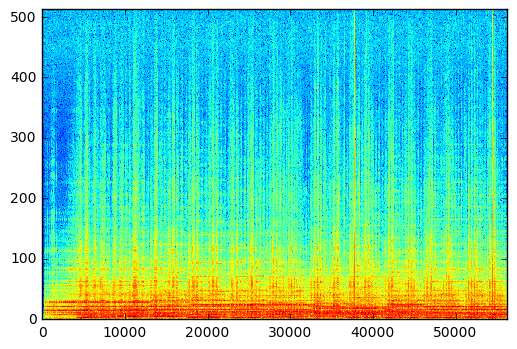

In [127]:
plt.imshow(log_spectrogram, origin='lower', aspect='auto',
           interpolation='nearest')

Now we'll specify for each moment of time `t` which preceding intervals of the form `[t-a,t-b]` we want to use for feature extraction. So if for each interval we have `N` different features, the total amount of different features we'll have is equal to `N * n_intervals`.

We want to have varied information from the audio, so we sample features not for every frame, but each `step_size` frames.

In [128]:
steps = [(-2000, -1), (-1000, -1), (-500, -1), (-100, -1), (-50, -1)]
min_offset = max([-(i[0]) for i in steps])
step_size = 10

In [129]:
min_offset

2000

We want to have the frequency content of an interval as a (vector) feature; but we have too many frequency bins, so we just reduce their number by summation of their content.

In [130]:
freq_avg_step = 27
num_freq_bins_reduced = log_spectrogram.shape[0]//freq_avg_step
print(num_freq_bins_reduced)

19


Some feature extraction functions

In [131]:
def get_avg_amplitude(spgram_slice):
    return np.sum(spgram_slice) / spgram_slice.shape[1]  # gets the average amplitude of the slice

In [132]:
def get_loudest_bin(spgram_slice):
    tmp = np.sum(spgram_slice, axis=1)
    return np.argmax(tmp) / spgram_slice.shape[1]
# returns the index of the loudest frequency bin, the slice is averaged

Now we let's extract the features and the spectral content for each frame

In [133]:
N_prev_f = 1

In [134]:
nfeat = 2 * len(steps) + num_freq_bins_reduced
# number of features - we have 2 scalar features for each slice of audio + frequency bins (enlarged) for previous frame
# plus we have N_prev_f previous values of the bin amplitude, but we'll store that separately

In [135]:
def get_features_for_frame(log_spgram_slice, scalar_functions, n_features):
    res = np.zeros(n_features)
    counter = 0
    for s_f in scalar_functions:
        for slicing in steps:
            a = min_offset + slicing[0]
            b = min_offset + slicing[1]
            res[counter] = s_f(log_spgram_slice[:, a:b])
            counter += 1
    for j in range(num_freq_bins_reduced):
        res[counter + j] = np.sum(log_spgram_slice[j * freq_avg_step:(j+1) * freq_avg_step, -1])
    return res

In [136]:
def process_spectrogram(log_spgram, scalar_functions, n_slices, n_features):
    # features, frequency content - X, Y
    # n_slices - the number of data points
    loc_Y = np.zeros([n_slices, log_spgram.shape[0]])
    loc_X = np.zeros([n_slices, n_features + N_prev_f])
    for i in range(n_slices):
        if i%200 == 0:
            print(i)
        loc_Y[i] = log_spgram[:, min_offset + step_size * i]
        loc_X[i, 0:n_features] = get_features_for_frame(log_spgram[:,step_size * i:min_offset
                                                                     + step_size * i], scalar_functions, n_features)
#         for j in range(log_spgram.shape[0]):
#             loc_X[j, i, n_features:n_features + N_prev_f] = log_spgram[j, min_offset + step_size * i
#                                                                        - 1 - N_prev_f:min_offset + step_size * i
#                                                                        - 1]
    return [loc_X, loc_Y]

In [140]:
n_samples = 2000

start_time = perf_counter()
X, Y = process_spectrogram(log_spectrogram, [get_avg_amplitude, get_loudest_bin],
                           n_samples, nfeat)
print(perf_counter() - start_time)

0
200
400
600
800
1000
1200
1400
1600
1800
5.986549857000227


Next, we scale the features.

In [141]:
# N_prev_f = 0, 4.949 4.977
# N_prev_f = 0, 4.95
# no extraction, 0.377
# get_loudest_bin - 0.966
# get_avg_ampl - 4.1797

In [142]:

# for i in range(log_spectrogram.shape[0]):
feature_scaler_freq = StandardScaler()
X = feature_scaler_freq.fit_transform(X)
#     feature_scaler_list.append(feature_scaler_freq)

freq_Y_mean = np.mean(Y)
freq_Y_std = np.std(Y)

Y = (Y - freq_Y_mean) / freq_Y_std

Then, we train a regressor for each frequency band

In [143]:
predictors = []
for i in range(Y.shape[1]):
    if i%50 == 0:
        print(i)
    predictor = LinearRegression()
    predictor.fit(X, Y[:, i])
    predictors.append(predictor)

0
50
100
150
200
250
300
350
400
450
500


Let's then try and generate some new audio (frequency and phase) and compare it with the real audio, to assess the performance of our model. First, we'll take a chunk of the audio that hasn't been fed to our model before, to use a starting point.
At some point, the model will only generate audio based on only newly generated audio.

In [153]:
do_CV = True

keep_starting_audio = False  # if False, we cut off the seed audio
gen_start = min_offset + n_samples * step_size
print(gen_start, min_offset)  # the starting point of the seed audio and the length of the seed audio
generate_size = 20000  # how many samples we want to generate
result = np.zeros([log_spectrogram.shape[0], generate_size + min_offset])
result_phase = np.random.rand(log_spectrogram.shape[0], generate_size + min_offset) * 2 * 3.141
feat_arr = np.zeros([1, nfeat + N_prev_f])

for i in range(min_offset):
    result[:, i] = log_spectrogram[:, gen_start + i]
max_val = np.max(result) * 1.

for i in range(generate_size):
    if i%100 == 0:
        print(i)
    feat_arr[0,:nfeat] = get_features_for_frame(result[:, i:i+min_offset],
                                                 [get_avg_amplitude, get_loudest_bin],nfeat)
    for k in range(log_spectrogram.shape[0]):
        feat_arr[0,nfeat:] = result[k, min_offset + i - 1 - N_prev_f:min_offset + i - 1]
        result[k, min_offset+i] = predictors[k].predict(feature_scaler_freq.transform(feat_arr))
        result[k, min_offset+i] *= freq_Y_std  # now we rescale it back
        result[k, min_offset+i] += freq_Y_mean
        if result[k, min_offset+i] > max_val:
            result[k, min_offset+i] = max_val

22000 2000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
183

In [154]:
print(mean_squared_error(result[:, min_offset:],
                         log_spectrogram[:, gen_start + min_offset:gen_start + min_offset + generate_size]))

352.791634382


In [155]:
result.shape

(513, 22000)

In [156]:
if not keep_starting_audio:
    result = result[:, min_offset:]
    result_phase = result_phase[:, min_offset:]

Let's now generate some audio based on an audio 'seed' (in this case, a chunk of the original waveform).
At some point, the model will only generate audio based on only newly generated audio.

In [163]:
np.max(result), max_val

(14.294213170816956, 14.294213170816956)

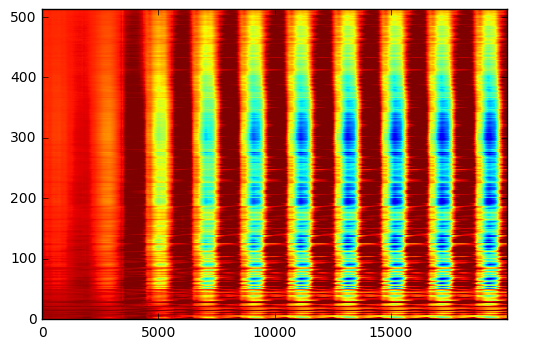

In [157]:
plt.imshow(result, origin='lower', aspect='auto',
           interpolation='nearest')

In [158]:
freq_amplitude = np.exp(result) - 1
result_complex = freq_amplitude * np.exp(1j * result_phase)

In [159]:
audio_dat = stft.ispectrogram(result_complex, framelength=framelength, overlap=overlap)

In [160]:
def write_stereo(a_l, a_r, s_r, name):
    a_s = np.zeros([a_l.shape[0], 2], dtype=np.int16)
    a_s[:, 0] = a_l
    a_s[:, 1] = a_r
    print(a_s.shape)
    wavfile.write(name, s_r, a_s)

In [161]:
write_stereo(audio_dat, audio_dat, 44100, 'reich-new.wav')

(5119744, 2)
